# Deep Dream in TensorFlow

In [35]:
import numpy as np
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib.request
import os
import zipfile
import imageio

In [4]:
#downloading Inception Net
url = ('https://storage.googleapis.com/download.tensorflow.org/models/'
           'inception5h.zip')
basename = 'inception5h.zip'
data_dir = ''
def download_model():
    local_zip_file = os.path.join(data_dir,basename)
    if not os.path.exists(local_zip_file):
        model_url = urllib.request.urlopen(url)
        with open(local_zip_file) as output:
            output.write(model_url.read())
    #Extracting the downloaded
    #zip file of the model.
    print('Extracting',local_zip_file)
    zip_ref = zipfile.ZipFile(local_zip_file,'r')
    zip_ref.extractall(data_dir)
    zip_ref.close()

In [5]:
download_model()

Extracting inception5h.zip


In [6]:
#some helper functions

#A method to show the
#image using matplotlib
def show_image(img):
    img = np.uint8(np.clip(img, 0, 1)*255)
    plt.imshow(img)
    plt.show()


#A method to save
#the image on the disk
def save_image(img,filename):
    img = np.uint8(np.clip(img, 0, 1)*255)
    pil_image = PIL.Image.fromarray(img)
    pil_image.save(filename)


#Resizing the image
#helpful while training
def resize(img,size):
    #First we will convert numpy image
    #to PIL image, convention for
    #height and width is opposite
    #in PIL and numpy hence we
    #reverse the size.
    size = tuple(reversed(size))
    img = np.clip(img,0.0,255.0)
    img = img.astype(np.uint8)
    img = PIL.Image.fromarray(img)
    img = img.resize(size, PIL.Image.LANCZOS)
    img = np.float32(img)
    return img

In [34]:
#tiled_gradients

#this function returns the actual
#size of the tiles in which we can
#divide our image
def get_tile_size(num_pixels,tile_size=512):
    num_tiles = int(round(num_pixels/tile_size))
    num_tiles = max(1,num_tiles)
    actual_tile_size = int(num_pixels/num_tiles)
    return actual_tile_size
    

#Since it would be computationally expensive
#to calculate the gradient with respect to the
#full image, instead we will calculate the gradients
#small portions(tiles) of the image. 
def tiled_gradients(img,gradients,tile_size=512):
    '''
    inputs:
        img: The input image
        gradients: A gradient node which holds the
            the operations to find the gradient w.r.t
            some input
        tile_size: smallest portion of the image
            of which we want to calculate the gradient
            at a time
    '''        
    #getting the height and width of the image
    w,h = img.shape[:2]
    
    #tile size along x axis
    x_tile_size = get_tile_size(w,tile_size)
    #tile size along y axis
    y_tile_size = get_tile_size(h,tile_size)
    x_start = 0
    grad = np.zeros_like(img)
    while(x_start < w):
        #last x cordinate of the tile
        x_end = x_start + x_tile_size
        #shouldnt be greater than the width
        #of the image
        x_end = min(w,x_end)
        y_start = 0
        while(y_start < h):
            y_end = y_start + y_tile_size
            y_end = min(h,y_end)
            #tile from the image
            img_tile = img[x_start:x_end,y_start:y_end,:]
            #calculating gradients w.r.t the tile of the image
            g = sess.run(gradients,{input_image : img_tile})
            g /= (np.std(g) + 1e-8)
            grad[x_start:x_end,y_start:y_end,:] = g
            y_start = y_end
        x_start = x_end
    return grad

In [14]:
def train(layer_act,img0,num_iter=10, lr=1.5,num_octaves=4,scale = 1.4,show_n_save=True):
    
    '''
    Inputs:
        layer_act: Activation of the input image at some layer.
        img0 : Input image
        num_iterations: number of iterations for training
        num_octaves: number of times we will downscale the image
        scale: amount by which we will downscale the image
        show_n_save: whether to plot and save the image or not.      
    '''
    
    #getting the score from the activations
    #by calculating the mean
    score = tf.reduce_mean(layer_act)
    
    #defining the gradient of the score w.r.t image
    gradients = tf.gradients(score,input_image)[0]
    img = img0.copy()
    
    #this list will contain different resolution copies
    #of our input image
    octaves = []
    for _ in range(num_octaves-1):
        size = img.shape[:2]
        #downscaling the image
        img_res = resize(img,np.int32(np.float32(size)/scale))
        #upscaling the downscaled image
        #and subtracting it from the current
        #image, so that we can late on do
        #the recombination.
        img_high = img - resize(img_res,size)
        octaves.append(img_high)
        img = img_res
    for i in range(num_octaves):
        if i > 0:
            img_high = octaves[-i]
            #combining the downscaled image with
            #the upscaled image.
            img = resize(img,img_high.shape[:2]) + img_high
        
        #Deep dreaming on the image
        for _ in range(num_iter):
            grad = tiled_gradients(img,gradients)
            #updating the image
            img += grad*(lr / (np.abs(grad).mean()+1e-7))
        if show_n_save:
            show_image(img/255)
            save_image(img/255,str(i)+'.jpg')
    return img

In [11]:
#Constructing computational graph
#from downloaded model

#the name of the proto buffer file
#of the inception model
model_fn = 'tensorflow_inception_graph.pb'
graph = tf.Graph()
#Starting an Interactive Session
sess = tf.InteractiveSession(graph = graph)
#opening the protobuffer
#file containing the graph.
with tf.gfile.FastGFile(os.path.join(data_dir,model_fn),'rb') as f:
    #graph_def will contain our graph object
    #this statement creates an empty graphdef object
    graph_def = tf.GraphDef()
    #Reading from the pb file
    #and parsing the graph object to graph_def
    graph_def.ParseFromString(f.read())

#placeholder for input_image
input_image = tf.placeholder(tf.float32,name='input_image')
#the mean of the images on which
#inception was trained on
image_net_mean = 117.0
#adding an extra dimension,since inception
#net expects the input in this form
#Also subtracting the imagenet mean from the image
image_prepro = tf.expand_dims(input_image - image_net_mean,0)
#Importing the graph from graph_def
tf.import_graph_def(graph_def, {'input':image_prepro})
#Storing the name of different layers of
#inception net in layers list
#we are only storing the names of Convolutional layers.
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

In [12]:
layers

['import/conv2d0_pre_relu/conv',
 'import/conv2d1_pre_relu/conv',
 'import/conv2d2_pre_relu/conv',
 'import/mixed3a_1x1_pre_relu/conv',
 'import/mixed3a_3x3_bottleneck_pre_relu/conv',
 'import/mixed3a_3x3_pre_relu/conv',
 'import/mixed3a_5x5_bottleneck_pre_relu/conv',
 'import/mixed3a_5x5_pre_relu/conv',
 'import/mixed3a_pool_reduce_pre_relu/conv',
 'import/mixed3b_1x1_pre_relu/conv',
 'import/mixed3b_3x3_bottleneck_pre_relu/conv',
 'import/mixed3b_3x3_pre_relu/conv',
 'import/mixed3b_5x5_bottleneck_pre_relu/conv',
 'import/mixed3b_5x5_pre_relu/conv',
 'import/mixed3b_pool_reduce_pre_relu/conv',
 'import/mixed4a_1x1_pre_relu/conv',
 'import/mixed4a_3x3_bottleneck_pre_relu/conv',
 'import/mixed4a_3x3_pre_relu/conv',
 'import/mixed4a_5x5_bottleneck_pre_relu/conv',
 'import/mixed4a_5x5_pre_relu/conv',
 'import/mixed4a_pool_reduce_pre_relu/conv',
 'import/mixed4b_1x1_pre_relu/conv',
 'import/mixed4b_3x3_bottleneck_pre_relu/conv',
 'import/mixed4b_3x3_pre_relu/conv',
 'import/mixed4b_5x5_bo

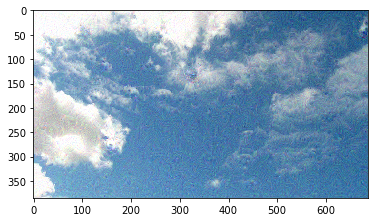

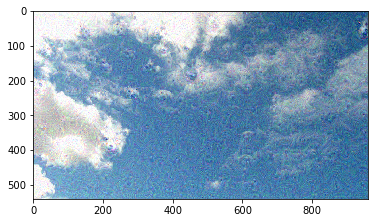

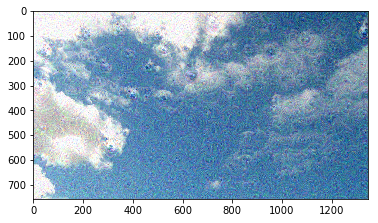

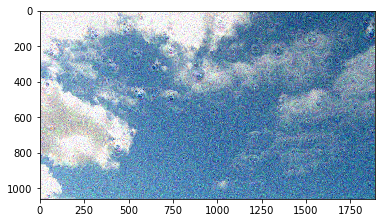

In [33]:
#opening the image we want to
#deep dream on
img0 = PIL.Image.open('sky.jpg')
#converting it into a numpy ndarray
img0 = np.float32(img0)
#selecting the layer at which we
#we will calculate the activations
layer = 'mixed4d_pool_reduce_pre_relu/conv'
#getting the activation tensor for that layer
layer_act = graph.get_tensor_by_name("import/%s:0"%layer)
#finally calling the train function
train(t_obj,img0,20)

In [ ]:
filename = 'flash.mp4'
#reader object for reading the video
#using imageio module for video processing
reader = imageio.get_reader(filename,'ffmpeg')
#getting number of frames and frames per second
fps = reader.get_meta_data()['fps']
nframes = reader.get_meta_data()['nframes']
img = []
#reading frames from video one by one
#and applying deep dream on them
for i in range(int(nframes-fps*10)):
    layer = 'mixed4c'
    t_obj = graph.get_tensor_by_name("import/%s:0"%layer)
    img.append(train(t_obj,reader.get_data(i),10,num_octaves=3,shownsave=False))
    print('done'+str(i))

#writing the dreamed frames into a video
writer = imageio.get_writer('dream','ffmpeg',fps = fps)
for i in range(len(img)):
    writer.append_data(img[i])
writer.close()
reader.close()
    


done0
done1
done2
done3
done4
done5
done6
done7
done8
done9
done10
done11
done12
done13
done14
done15
done16
done17
done18
done19
done20
done21
done22
done23
done24
done25
done26
done27
done28
done29
done30
done31
done32
done33
done34
done35
done36
done37
done38
done39
done40
done41
done42
done43
done44
done45
done46
done47
done48
done49
done50
done51
done52
done53
done54
done55
done56
done57
done58
done59
done60
done61
done62
done63
done64
done65
done66
done67
done68
done69
done70
done71
done72
done73
done74
done75
done76
done77
done78
done79
done80
done81
done82
done83
done84
done85
done86
done87
done88
done89
done90
done91
done92
done93
done94
done95
done96
done97
done98
done99
done100
done101
done102
done103
done104
done105
done106
done107
done108
done109
done110
done111
done112
done113
done114
done115
done116
done117
done118
done119
done120
done121
done122
done123
done124
done125
done126
done127
done128
done129
done130
done131
done132
done133
done134
done135
done136
done137
done13

# References

1. CS23n1 lecture on visualizing Convnets. "http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf"
2. Siraj Raval's video on Deep Dream. "https://www.youtube.com/watch?v=MrBzgvUNr4w&t=300s"
3. Hvass Laboratories tutorial on Deep Dream. "https://www.youtube.com/watch?v=ws-ZbiFV1Ms&t=257s"